# Contour-based evaluation

In [1]:
from metrics import compute_metric
import numpy as np

test_dir = '../../Results/hetero_uncertainty/ACDC/vxm_ACDC_hetero/'

dice_list, jc_list, hd_list, asd_list = compute_metric(test_dir)

print('dice', np.mean(dice_list))
print('jaccard', np.mean(jc_list))
print('hd', np.mean(hd_list))
print('asd', np.mean(asd_list))

dice 0.8072623503413928
jaccard 0.6845968518836318
hd 4.574908566066363
asd 1.2091974761871542


In [2]:
from metrics import compute_metric
import numpy as np

test_dir = '../../Results/hetero_uncertainty/CAMUS/vxm_CAMUS_hetero/'

dice_list, jc_list, hd_list, asd_list = compute_metric(test_dir)

print('dice', np.mean(dice_list))
print('jaccard', np.mean(jc_list))
print('hd', np.mean(hd_list))
print('asd', np.mean(asd_list))

dice 0.8196482335392077
jaccard 0.6979673405381288
hd 8.801071118698427
asd 1.6599926915702161


In [3]:
from metrics import compute_metric
import numpy as np

test_dir = '../../Results/hetero_uncertainty/ACDC/tsm_ACDC_hetero/'

dice_list, jc_list, hd_list, asd_list = compute_metric(test_dir)

print('dice', np.mean(dice_list))
print('jaccard', np.mean(jc_list))
print('hd', np.mean(hd_list))
print('asd', np.mean(asd_list))

dice 0.7812279455892794
jaccard 0.6500514887384299
hd 5.040038789949433
asd 1.2592082241076203


In [5]:
from metrics import compute_metric
import numpy as np

test_dir = '../../Results/hetero_uncertainty/CAMUS/tsm_CAMUS_hetero/'

dice_list, jc_list, hd_list, asd_list = compute_metric(test_dir)

print('dice', np.mean(dice_list))
print('jaccard', np.mean(jc_list))
print('hd', np.mean(hd_list))
print('asd', np.mean(asd_list))

dice 0.8038017260949181
jaccard 0.6761648512231798
hd 9.859107890215093
asd 1.720556727610815


# Uncertainty quantification

We employ sparsification error plots as a quantitative measure to evaluate the accuracy of our estimated variance, $\hat{\sigma}_I^2$. To generate these plots, we iteratively remove one pixel at a time in descending order of uncertainty magnitude and calculate the mean squared error (MSE) of the remaining pixels, given by $E_{\Omega - \Omega_x}[(I_f - \hat{I}_f)^2]$. Ideally, a sparsification error plot should exhibit a monotonic decrease, signifying that the estimated uncertainty map effectively identifies pixels with the largest errors.


In [6]:
from ause import compute_aucs
from scipy.io import loadmat, savemat
import seaborn as sns
import numpy as np
import os
sns.set_theme()

In [7]:
import matplotlib.pyplot as plt
from matplotlib import rc
font_size = 15
rc={'font.size' : font_size, 
    'font.family' : 'Arial',
    'axes.labelsize': font_size,   
    'legend.fontsize': font_size, 
    'axes.titlesize': font_size, 
    'xtick.labelsize': font_size, 
    'ytick.labelsize': font_size}
sns.set(font = 'Arial', rc=rc)
sns.set_style("ticks", {'axes.edgecolor': 'k', 
                        'axes.linewidth': 1, 
                        'axes.grid': True,
                        'xtick.major.width': 1,
                        'ytick.major.width': 1})

plt.rcParams.update({'figure.autolayout': False})

In [8]:
def cal_ause(result_dir_list, uncertainty_type, metric_name='mse', numOfSample=100):
    assert uncertainty_type in ['logsigma_image', 'logsigma_flow']
    numOfMethods = len(result_dir_list)
    numOfFiles = len(os.listdir(result_dir_list[0]))

    ause_list_all = []
    sparse_curve_list_all = []

    rand_indices = np.random.choice(numOfFiles, numOfSample) # save computation time
    
    for i_method in range(numOfMethods):
        # iterate through all samples
        
        ause_list = []
        sparse_curve_list = []
        for idx in rand_indices:

            file_name = os.listdir(result_dir_list[i_method])[idx]
            file = loadmat(os.path.join(result_dir_list[i_method], file_name))

            # pred = file['im_ES_pred']
            # gt = file['im_ES']
            if file[uncertainty_type].shape[-1] == 2: # for voxelmorph-diff
                uncertainty = np.log(np.exp(file[uncertainty_type][:,:,0]) + np.exp(file[uncertainty_type][:,:,1])) # log(sigma_x^2 + sigma_y^2)
                metric_out, sparse_curve, opt_curve, plotx = compute_aucs(gt=file['im_ES'], pred=file['im_ES_pred'], uncert=uncertainty)
            elif file[uncertainty_type].shape[-1] == 3: # for voxelmorph-diff
                uncertainty = np.log(np.exp(file[uncertainty_type][:,:,:,0]) + np.exp(file[uncertainty_type][:,:,:,1]) + np.exp(file[uncertainty_type][:,:,:,2])) # log(sigma_x^2 + sigma_y^2)
                metric_out, sparse_curve, opt_curve, plotx = compute_aucs(gt=file['im_ES'], pred=file['im_ES_pred'], uncert=uncertainty)
            else:
                metric_out, sparse_curve, opt_curve, plotx = compute_aucs(gt=file['im_ES'], pred=file['im_ES_pred'], uncert=file[uncertainty_type])

                # plt.imshow(file[uncertainty_type])
                # plt.show()

            ause_list.append(metric_out[metric_name])
            sparse_curve_list.append(sparse_curve[metric_name])
        
        ause_list_all.append(ause_list)
        sparse_curve_list_all.append(sparse_curve_list)
    
    return ause_list_all, sparse_curve_list_all, plotx

In [9]:
def plot_ause(sparse_curve_arr, ause_arr, plotx, result_names):
    fig, axes = plt.subplots(1, 1)
    fig.set_size_inches(6,5)

    for i in range(len(result_names)):
        axes.plot(np.array(plotx), sparse_curve_arr[i], label=str(result_names[i])+' (%.5f)' % ause_arr[i][0])
    axes.legend(loc='upper right')
    axes.set_xlabel('Removing x fraction of voxels')
    axes.set_ylabel('Sparsification Error for MSE')

    return fig

In [10]:
result_dir = '../../Results/hetero_uncertainty/ACDC/vxm_ACDC_hetero/'

result_dir_list = [result_dir]
numOfSamples = len(os.listdir(result_dir))

ause_list, sparse_curve_list, plotx = cal_ause(result_dir_list, 'logsigma_image', numOfSample=numOfSamples)

ause_arr = np.array(ause_list)
sparse_curve_arr = np.array(sparse_curve_list)

ause_arr = np.mean(ause_arr, axis=1)
sparse_curve_arr = np.mean(sparse_curve_arr, axis=1) # average across selected samples

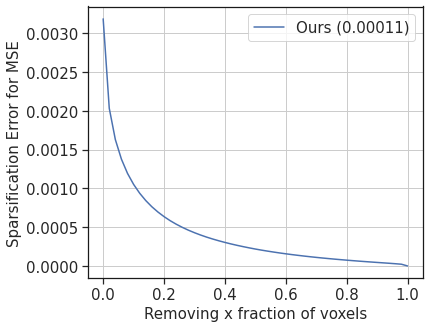

In [11]:
result_names = ['Ours']
fig = plot_ause(sparse_curve_arr, ause_arr, plotx, result_names)